# TP2
### Étudiant
    1. Félix Moreau 1846157
    2. Axel Massucci Templier 1837967
    3. Hermann Noubissie Noussa 1901259
    4. Pierre-Olivier Côté 1848609


In [14]:
import yfinance as yf 
from pandas_datareader import data, wb
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import mean_squared_error
#from sklearn.feature_selection import RFE
import math as mt
#import statsmodels.formula.api as smf
#from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
#from sklearn.ensemble import RandomForestClassifier
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import talib
import pylab
from sklearn import preprocessing

In [15]:
start_sp = datetime.datetime(2020,1,1)
end_sp = datetime.datetime(2020,4,1)

# Use Vanguard ETF
# SP500 Index + 11 Industry
BLack_ETF=['IVV','IWF','IJH','IJR','IWM','IWD','ITOT','IVW','IWB','IWR','DVY',
           'IVE','IWP','IWS','IWV','IUSG','IWO','IWN','IBB','IJK','IUSV',
           'OEF','IJS','IJJ','IYW','IHI','IJT','ITA','IGV','IYH','SOXX','EWC',
           'IGM','IYF','JKE','SUSA','IDU','IYY','IYG','JKD','IYC','IYJ','JKG',
           'IWC','IYK','JKF','JKH','IYT','JKI','IYZ','IGE','IYE','JKL','IYM',
           'JKJ','JKK','IGN']
BLack_ETF_sansIVW = ['IVV','IWF','IJH','IJR','IWM','IWD','ITOT','IWB','IWR','DVY',
           'IVE','IWP','IWS','IWV','IUSG','IWO','IWN','IBB','IJK','IUSV',
           'OEF','IJS','IJJ','IYW','IHI','IJT','ITA','IGV','IYH','SOXX','EWC',
           'IGM','IYF','JKE','SUSA','IDU','IYY','IYG','JKD','IYC','IYJ','JKG',
           'IWC','IYK','JKF','JKH','IYT','JKI','IYZ','IGE','IYE','JKL','IYM',
           'JKJ','JKK','IGN']


In [6]:
def get_Data_bin(ticker,debut,fin):
    Data = yf.download(ticker, start=debut, end=fin,group_by="ticker")
    rendement = pd.DataFrame(index=Data.index)
    rendement['0'] = (Data['Close']-Data['Open'])/Data['Open']*100
    rendement_bin = pd.DataFrame(np.where(rendement['0'].shift(-1) > rendement['0'], 1, 0),
                                index = rendement.index)
    return rendement_bin, Data, rendement['0']


In [3]:
def data_preprocessing(ticker, Data):
    dataset = pd.DataFrame(index = Data.index)
    dataset['H-L'] = Data['High'] - Data['Low']
    dataset['O-C'] = Data['Close'] - Data['Open']
    
    dataset['ma_5'] = Data['Close'].rolling(window=5).mean()
    dataset['ma_10'] = Data['Close'].rolling(window=10).mean()
    
    dataset['EWMA_12'] = Data['Close'].ewm(span=12).mean()

    dataset['std_5'] = Data['Close'].rolling(window=5).std()
    dataset['std_10'] = Data['Close'].rolling(window=10).std()
    
    dataset['Williams %R'] = talib.WILLR(Data['High'].values,
                                         Data['Low'].values, Data['Close'].values, 7)
    #RSI
    dataset['RSI'] = talib.RSI(Data['Close'], timeperiod = 14)
    #conditions  = [dataset['RSI'] >= 70, (dataset['RSI'] < 70) & (dataset['RSI']> 30), dataset['RSI'] <= 30 ]
    #choices     = [ -1, 0, 1 ]
    #dataset['RSI'] = np.select(conditions, choices, default=np.nan)

    #MFI
    dataset['MFI'] = talib.MFI(Data['High'], Data['Low'], Data['Close'], Data['Volume'], timeperiod=14)
    #conditions  = [dataset['MFI'] >= 70, (dataset['MFI'] < 70) & (dataset['MFI']> 30), dataset['MFI'] <= 30 ]
    #choices     = [ -1, 0, 1 ]
    #dataset['MFI'] = np.select(conditions, choices, default=np.nan)
    
    #BBANDS
    #dataset['BBANDS_UP'], centre, dataset['BBANDS_DOWN'] = talib.BBANDS(
    #    Data['Close'],timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
                                                                                       
    #STOCHASTIC  
    dataset['STO_k'], dataset['STO_d'] = talib.STOCH(Data['High'], Data['Low'], Data['Close'],
                         fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    #k = dataset['STO_k']
    #d = dataset['STO_d']
    #conditions  = [(k>=80)&(d>=80),(k<80)&(d<80)&(k>=20)&(d>=20),(k<20)&(d<20)]
    #dataset['STO'] = np.select(conditions, choices, default=np.nan)
    
    #MACD
    macd, dataset['MACD'], macdhist = talib.MACD(Data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    #conditions  = [dataset['MACD'] < 0,dataset['MACD']==0 , dataset['RSI'] > 0 ]
    #choices     = [ -1, 0, 1 ]
    #dataset['MACD'] = np.select(conditions, choices, default=np.nan)
    
    #ADX
    dataset['ADX'] = talib.ADX(Data['High'], Data['Low'], Data['Close'], timeperiod=14)
    
    #SMA
    dataset['SMA'] = talib.SMA(Data['Close'], timeperiod=30)
    
    #SAR
    dataset['SAR'] = talib.SAR(np.array(Data['High']), np.array(Data['Low']), 0.2, 0.2)
    
    return dataset

#### Nous avons décidé de laisser en donné brute pour chaque signal afin que le modèle découvre lui-même a partir de quel nombre on doit vendre ou acheter!!

In [4]:
def getXY(etf_trouve,debut,fin):
    X=pd.DataFrame()
    Y=pd.DataFrame()
    for etf in etf_trouve:
        Y_bin, Data, rendement_ticker = get_Data_bin(etf,debut,fin)
        dataset_ini = data_preprocessing(etf, Data)
        X = pd.concat([X,dataset_ini])
        Y = pd.concat([Y,Y_bin])
    X['Y'] = Y
    X = X.dropna()
    Y1 = X['Y']
    X1 = X.drop(columns = ['Y'])
    X2 = pd.DataFrame(preprocessing.scale(X1), columns=X1.columns, index=X1.index)
    #Décaler la matrice pour prédire le jour d'après
    X = X2.iloc[0:-1,:]
    Y = Y1.iloc[1:]
    rendement_ticker = rendement_ticker.loc[Y.index]
    return X,Y, rendement_ticker

In [6]:
X,Y,rend = getXY(BLack_ETF,start_sp,end_sp)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
df = pd.DataFrame([data.DataReader(etf, 'yahoo', start_sp, end_sp)['Adj Close'] for etf in BLack_ETF]).T
df.columns = BLack_ETF
rendement = df.pct_change()

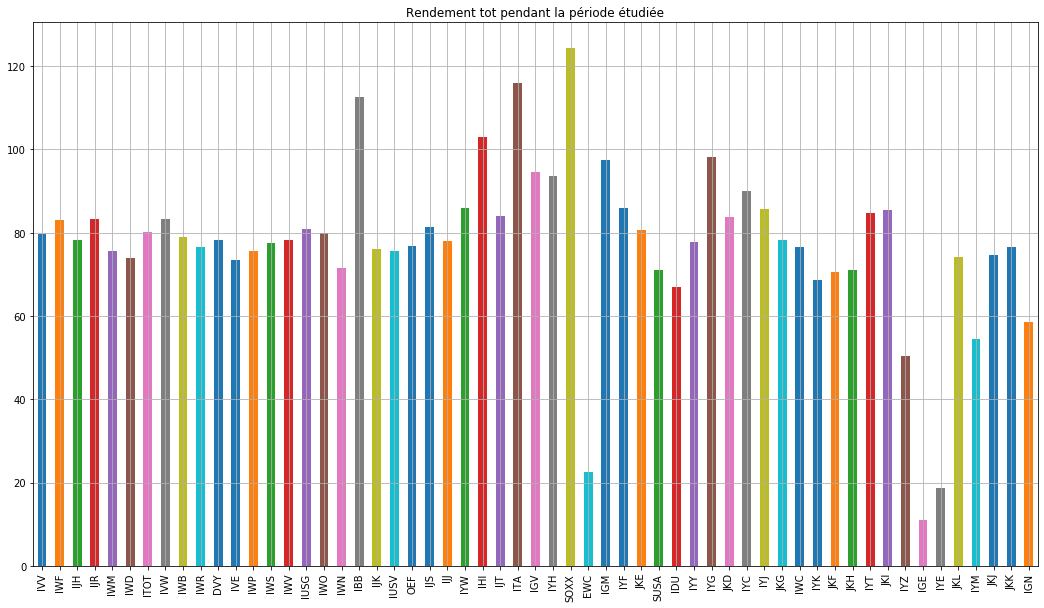

In [8]:
somme = rendement.sum()*100
somme.plot(kind='bar', grid=True, title = 'Rendement tot pendant la période étudiée',figsize=(18, 10))

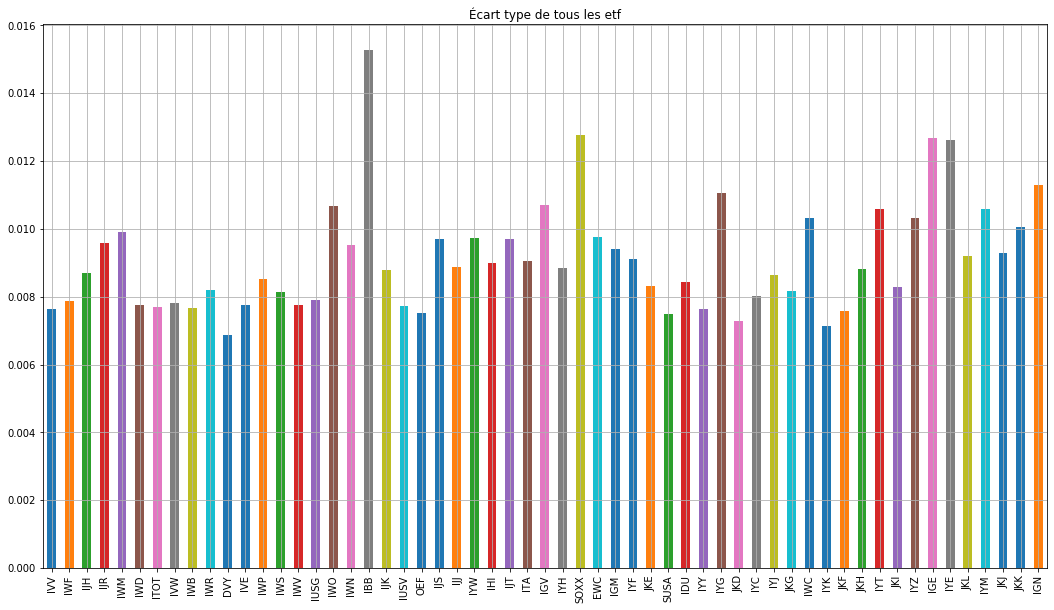

In [9]:
ecart_type=rendement.std()
ecart_type.plot(kind='bar', grid=True, title = 'Écart type de tous les etf',figsize=(18, 10))

# 1) Modele Logit

In [10]:
def calculate_aic(n, mse, num_params):
    aic = n * mt.log(mse) + 2 * num_params
    return aic

In [11]:
def calculModelLogit(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 0)
    ModeleLogit = LogisticRegression()
    TrainFit = ModeleLogit.fit(trainX, trainY)
    TrainScores = ModeleLogit.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleLogit.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleLogit.predict(testX)
    proba = ModeleLogit.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, ModeleLogit.coef_, testY, ModeleLogit, proba, trainY, trainX

In [12]:
def getROC(yTest, prediction, proba):
    fpr, tpr, thres = roc_curve(yTest, proba)
    ac = roc_auc_score(yTest, prediction)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % ac)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
def getMC(yTest, prediction):
    matrice = confusion_matrix(yTest, prediction)
    print(matrice) 

In [14]:
predictions, TrainScores, TestsScorelogit, aic, coefficientModel, testY, model, proba, trainY, trainX = calculModelLogit(X, Y)

Train score= 0.5172241101770703
Test score= 0.5168600283782656
AIC score : -17399.129846761007


Pour l'echantillon d'entrainement

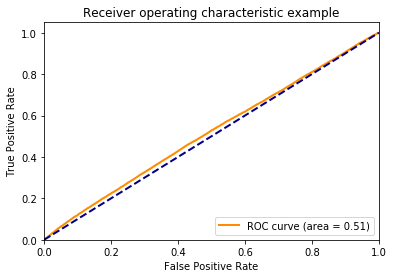

In [15]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [16]:
getMC(trainY, model.predict(trainX))

[[21513  7006]
 [19986  7405]]


Pour l'echantillon test

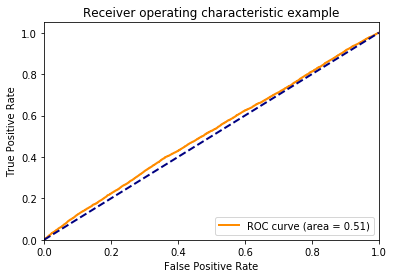

In [17]:
getROC(testY, predictions, proba)

In [18]:
getMC(testY, predictions)

[[9221 3003]
 [8574 3164]]


In [19]:
variableImportante2 = pd.DataFrame(coefficientModel, columns=X.columns).T
var2 = variableImportante2.sort_values(by=0,ascending = False)
var2

,0
SAR,0.136811
std_5,0.078639
STO_d,0.069004
RSI,0.031699
O-C,0.026465
ma_5,0.026163
H-L,0.020604
ADX,0.017527
Williams %R,0.006903
MACD,-0.008487


## Changer les paramètres afin d'avoir une meilleure classification

In [20]:
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
feature_list = list(X.columns)
rfe = RFE(model,8)
rfe = rfe.fit(X, Y)
print(rfe.support_)
print(rfe.ranking_)
rapport = rfe.support_

nouvelleBD = X
## On veut visualiser les variables qui ne sont pas sélectionnées
for i in range(0,len(rapport)):
    if rapport[i]==False :
        sigle = X
        print("Le paramètre:",feature_list[i], "n'est pas selectionné")
        nouvelleBD = nouvelleBD.drop(columns = feature_list[i])

[False False False  True  True  True False  True False False  True  True
 False False  True  True]
[3 7 8 1 1 1 2 1 4 5 1 1 6 9 1 1]
Le paramètre: H-L n'est pas selectionné
Le paramètre: O-C n'est pas selectionné
Le paramètre: ma_5 n'est pas selectionné
Le paramètre: std_10 n'est pas selectionné
Le paramètre: RSI n'est pas selectionné
Le paramètre: MFI n'est pas selectionné
Le paramètre: MACD n'est pas selectionné
Le paramètre: ADX n'est pas selectionné


In [21]:
predictions, TrainScores, TestsScorelogit, aic, coefficientModel, testY, model, proba, trainY, trainX = calculModelLogit(nouvelleBD, Y)

Train score= 0.5185118941155429
Test score= 0.5160253735080544
AIC score : -17373.769691502148


Pour l'echantillon d'entrainement 

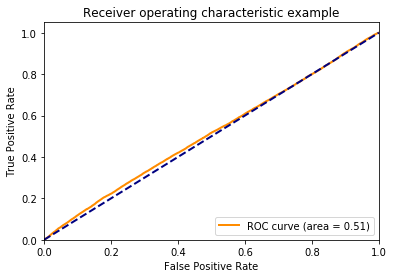

In [22]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [23]:
getMC(trainY, model.predict(trainX))

[[23252  5267]
 [21653  5738]]


Pour l'echantillon test

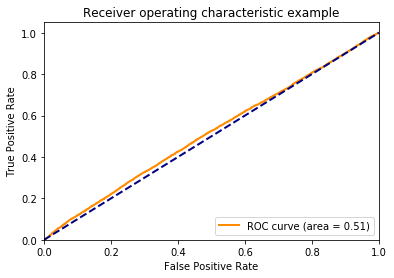

In [24]:
getROC(testY, predictions, proba)

In [25]:
getMC(testY, predictions)

[[9959 2265]
 [9332 2406]]


In [26]:
coefficientModel

array([[-0.06788978, -0.14814323,  0.04392049,  0.0431147 , -0.10797866,
         0.05218113, -0.1286583 ,  0.32527471]])

#### Le AIC, en utilisant la méthode récursive à diminuer, par contre, l'accuracy rester le même. Le % du test est de 51,6% ce qui est plus grand que 50%.

# 2) Arbre de decision

In [27]:
def calculModelArbreDecision(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 0)
    ModeleArbre = DecisionTreeClassifier()
    
    TrainFit = ModeleArbre.fit(trainX, trainY)
    
    TrainScores = ModeleArbre.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleArbre.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleArbre.predict(testX)
    
    proba = ModeleArbre.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, testY, testX, proba, trainY, trainX, ModeleArbre

In [28]:
predictions, TrainScores, TestsScoretree, aic, testY, testX, prob, trainY, trainX, model = calculModelArbreDecision(X, Y)

Train score= 1.0
Test score= 0.5355980302145062
AIC score : -18346.968720388904


Pour l'echantillon d'entrainement

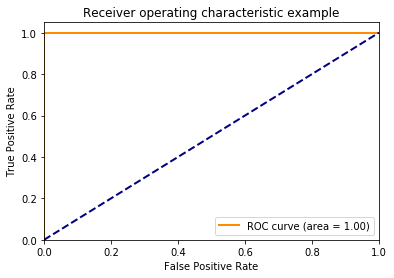

In [29]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [30]:
getMC(trainY, model.predict(trainX))

[[28519     0]
 [    0 27391]]


Pour l'echantillon test

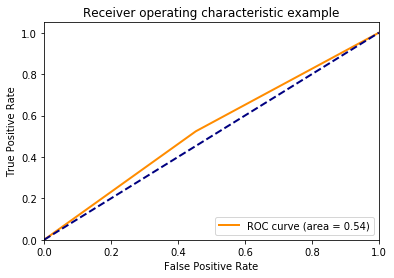

In [31]:
getROC(testY, predictions, prob)

In [32]:
getMC(testY, predictions)

[[6684 5540]
 [5588 6150]]


Avec les variables sélectionnées par le modèle Logit

In [33]:
nouvellePredictions, nouveauTrainScores, nouveauTestsScore, nouveauAIC, nouveautestY, nouveautestX, prob, nouveauTrainY, nouveautrainX, nouveauModel = calculModelArbreDecision(nouvelleBD, Y)

Train score= 1.0
Test score= 0.5219931558300642
AIC score : -17671.076529231654


Pour l'echantillon d'entrainement

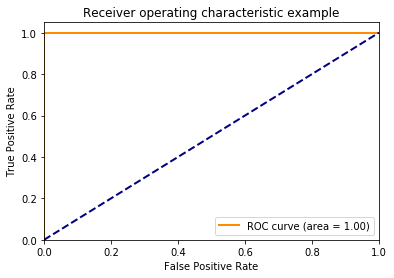

In [34]:
getROC(nouveauTrainY, nouveauModel.predict(nouveautrainX), nouveauModel.predict_proba(nouveautrainX)[:,1])

In [35]:
getMC(nouveauTrainY, nouveauModel.predict(nouveautrainX))

[[28519     0]
 [    0 27391]]


Pour l'echantillon test

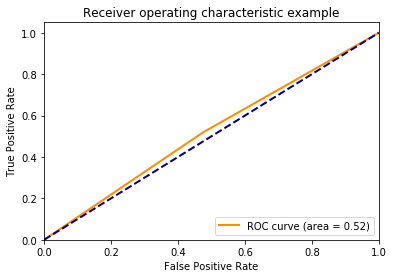

In [36]:
getROC(nouveautestY, nouvellePredictions, prob)

In [37]:
getMC(nouveautestY, nouvellePredictions)

[[6425 5799]
 [5655 6083]]


### Diminution de la précision de 2% lorsqu'on utilise les paramètres sélectionnés par l'arbre de décision

# Random Forest

In [38]:
def calculModelRandomForest(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    ModeleRF = RandomForestClassifier()
    
    TrainFit = ModeleRF.fit(trainX, trainY)
    
    TrainScores = ModeleRF.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleRF.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleRF.predict(testX)
    
    proba = ModeleRF.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    variableImportante = ModeleRF.feature_importances_
    return predictions, TrainScores, TestsScore, aic, testY, variableImportante, proba, trainY, trainX, ModeleRF

In [39]:
predictions, TrainScores, TestsScoreforest, AIC, testY, variableImportante, prob, trainY, trainX, modelRF = calculModelRandomForest(X, Y)

Train score= 1.0
Test score= 0.5863450463233453
AIC score : -21119.810871660928


Pour l'echantillon d'entrainement 

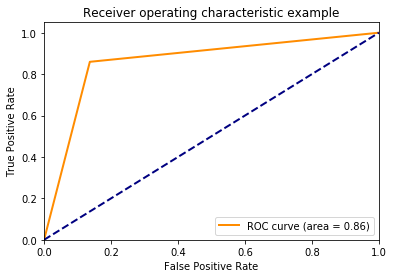

In [40]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [41]:
getMC(trainY, model.predict(trainX))

[[24645  3903]
 [ 3845 23517]]


Pour l'echantillon test

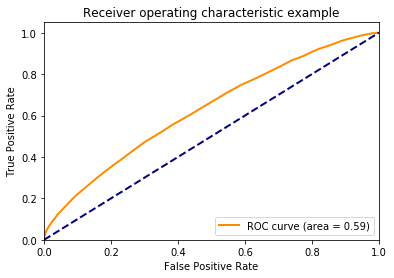

In [42]:
getROC(testY, predictions, prob)

In [43]:
getMC(testY, predictions)

[[7990 4205]
 [5707 6060]]


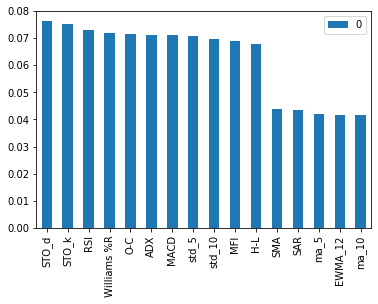

In [44]:
variableImportante1 = pd.DataFrame(variableImportante, index=X.columns)
variableImportante1.sort_values(by=0,ascending = False).plot(kind='bar')

#### Les variables importantes du Random Forest sont :
#### - O-C
#### - Williams %R
#### - Stochastique_k
#### - RSI
#### - Stochastique_d
#### Les variables importantes du Logit sont :
#### - O-C	
#### - MACD	
#### - SMA
#### - EWMA_12	
#### - STO_k
##### La différence est que le modèle logit utilise des valeurs que ne varie pas beaucoup et qui sont assez stable comparativement à random forest qui choisi des variables qui bougent beaucoup

# Répétez l’exercices pour des méthodes plus flexibles mais opaques.

In [45]:
from sklearn.svm import SVC 
def calculModelSVM(X,Y,typ):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    ModeleSVM = SVC(kernel=typ)
    
    TrainFit = ModeleSVM.fit(trainX, trainY)
    
    TrainScores = ModeleSVM.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleSVM.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleSVM.predict(testX)
    #proba = ModeleSVM.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, testY, trainY, trainX, ModeleSVM

In [46]:
predictions, TrainScores, TestsScorelin, aic, testY, trainY, trainX, ModeleSVM = calculModelSVM(X,Y,'linear')

Train score= 0.5144875693078161
Test score= 0.5081378849845589
AIC score : -16970.40137872718


Pour l'echantillon test

In [47]:
getMC(testY, predictions)

[[11798   397]
 [11389   378]]


In [48]:
predictions, TrainScores, TestsScoreradial, aic, testY, trainY, trainX, model = calculModelSVM(X,Y,'rbf')

Train score= 0.5719191557860848
Test score= 0.5490777063684167
AIC score : -19052.78056462676


Pour l'echantillon test

In [49]:
getMC(testY, predictions)

[[9299 2896]
 [7909 3858]]


# Comparer une dernière fois, l’ensemble des modèles, sélectionnez-en un et expliquez votre choix.

In [50]:
accuracy = pd.DataFrame([TestsScorelogit,TestsScoreforest,TestsScoretree, TestsScoreradial,TestsScorelin],
                       index = ['Logit','Forest','Tree','Radial','Linéaire'], columns = ['%Tests'])*100
accuracy

,%Tests
Logit,51.602537
Forest,58.634505
Tree,53.559803
Radial,54.907771
Linéaire,50.813788


#### Le modèle le plus précis est celui du random forest avec 58%. Il fait tout les possibilités possibles ce qui rend son modele précis dans ce cas.

# Répétez l’exercice mais cette fois-ci pour chaque ETF pris individuellement.

In [51]:
modele_unique = pd.DataFrame(index = BLack_ETF)
testscore=[]
AIC = []
for etf in BLack_ETF:
    X,Y,rend = getXY([etf],start_sp,end_sp)
    predictions, TrainScores, TestsScoreforest, aic, testY, variableImportante, prob, trainY, trainX, model = calculModelRandomForest(X, Y)
    testscore.append(TestsScoreforest)
    AIC.append(aic)
modele_unique['test %']=testscore
modele_unique['AIC']=AIC

[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.4268867924528302
AIC score : -204.02893304195757
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.4268867924528302
AIC score : -204.02893304195757
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.38443396226415094
AIC score : -173.73033231352807
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.39858490566037735
AIC score : -183.59124187117743
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.4033018867924528
AIC score : -186.9298417978815
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.4410377358490566
AIC score : -214.62948517705445
[*********************100%***********************]  1 of 1 completed
Train score= 1.0
Test score= 0.42924

In [52]:
modele_unique

,test %,AIC
IVV,0.426887,-204.028933
IWF,0.426887,-204.028933
IJH,0.384434,-173.730332
IJR,0.398585,-183.591242
IWM,0.403302,-186.929842
IWD,0.441038,-214.629485
ITOT,0.429245,-205.777389
IVW,0.433962,-209.296082
IWB,0.450472,-221.846681
IWR,0.398585,-183.591242


In [53]:
modele_unique.mean(axis=0)

test %      0.423327
AIC      -199.746733
dtype: float64

En utilisant un modele pour chaque ETF, il est évident que le modèle sera moins efficace pour généraliser sur les autres ETF, donc il faudrait créer un modèle a chaque fois qu'on veut savoir pour un stock. L'accuracy est même plus petite pour chaque modèle pris séparer.

Source :

https://github.com/mrjbq7/ta-lib

https://medium.com/@rbhatia46/using-svm-on-top-of-technical-indicators-to-predict-reliance-stock-prices-abb494d9f45f

## Ajout

In [54]:
def rendementmodel(ticker,debut,fin):
    rendement_tot=0
    rendement=0
    rend_graph=[]
    rend_graphique = pd.DataFrame()
    for tick in ticker:
        X, Y, rend = getXY([tick],debut,fin)
        pred = modelRF.score(X,Y)
        prediction = modelRF.predict(X)
        for i in range(len(prediction)-1): 
            if prediction[i]==1:
                rendement = rend[i+1]
            elif prediction[i]==0:
                rendement = -rend[i+1]
            rendement_tot += rendement
            rend_graph.append(rendement_tot)
        rend_graphique[tick] = np.transpose(rend_graph)
        rend_graph=[]
        rendement_tot=0
        rendement=0
    return rendement_tot,rend_graphique, rend      

In [55]:
start_sp_test = datetime.datetime(2017,12,31)
end_sp_test = datetime.datetime(2019,12,31)
rend, rend_graph, rend = rendementmodel(BLack_ETF_sansIVW,start_sp_test,end_sp_test)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

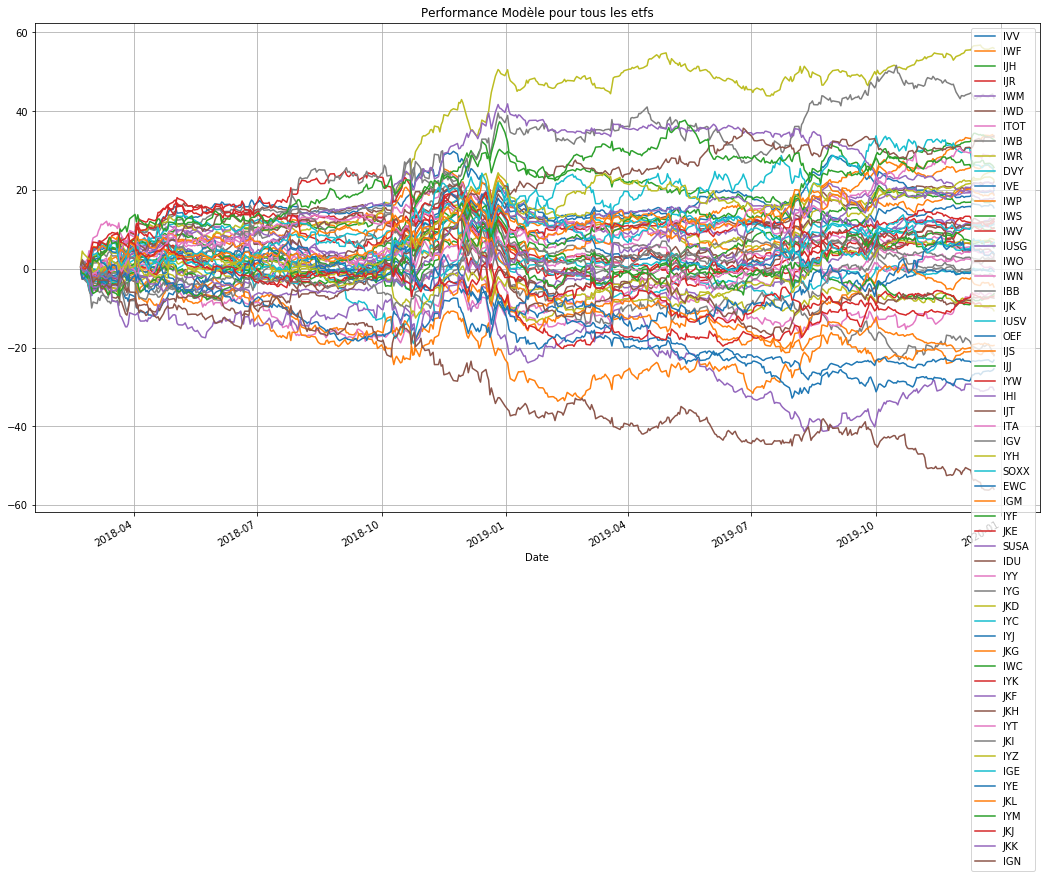

In [56]:
rend_graph.index = rend.index[0:-1]
rend_graph.plot(grid=True, title = 'Performance Modèle pour tous les etfs',figsize=(18, 10))

In [57]:
rendement = pd.DataFrame(rend_graph.mean(axis=1),index=rend.index[0:-1],
                         columns=['Moyenne Black ETF avec modèle Random Forest'])

In [58]:
#IVW
Data = yf.download('IVW', start=start_sp_test, end=end_sp_test,group_by="ticker")
IVW = pd.DataFrame(Data['Close'].pct_change().cumsum()*100,index=rend.index[0:-1])
IVW.columns=['ETF émitant le SP500']
Figure=pd.concat([rendement, IVW.reindex(rendement.index)], axis=1)

[*********************100%***********************]  1 of 1 completed


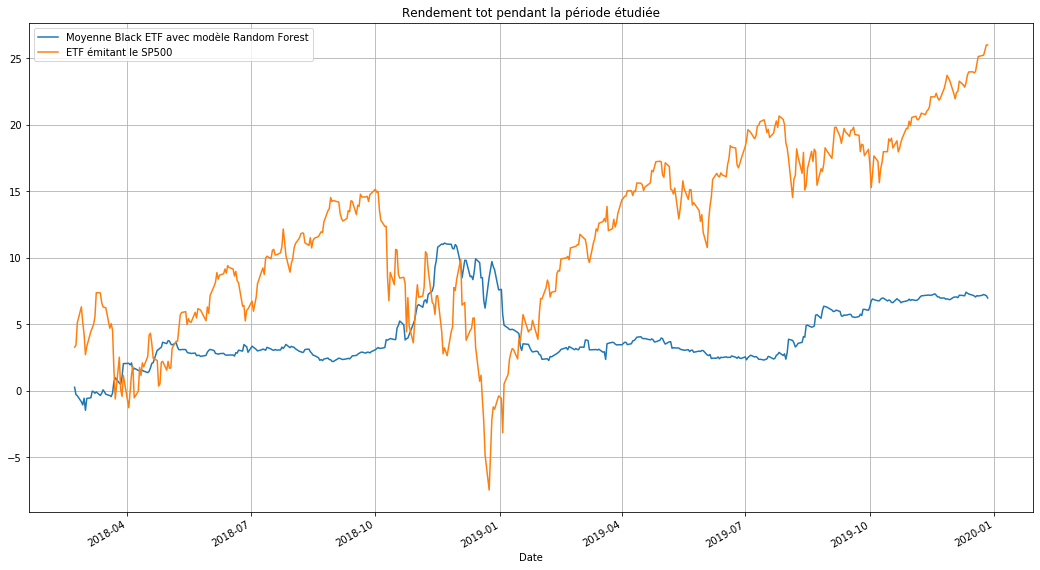

In [59]:
Figure.plot(grid=True, title = 'Rendement tot pendant la période étudiée',figsize=(18, 10))

### Conclusion : On a pas réussi a dépasser le SP500 en prennant la moyenne de tous les rendements, on pourrait utiliser le TP1 pour pondéré afin d'avoir de meilleurs résultats!